# LMU Model

## 1. Importing Libraries and Preprocessing Data

In [3]:
# Import libraries
import time
import numpy as np
from scipy.interpolate import make_splrep
from scipy.io import loadmat
import nengo
import nengo_dl
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

from nengo.utils.filter_design import cont2discrete

import sys
sys.path.append('/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/src/utils')
from LMU_Stack import LMUStack

/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/venv/lib/python3.10/site-packages/nengo_dl/version.py:58: UserWarning: This version of NengoDL has not been tested with your Nengo version (4.0.0). The latest fully supported version is 3.2.0.
  warnings.warn(warnstr)


In [4]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Get Neuron data from .csv files
datafile_path = f"./../../Data Extraction/Extracted Data/{monkey}_raw.csv"
df = pd.read_csv(datafile_path)
headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]
activity_matrix_t = activity_matrix.transpose().to_numpy()

kinem_matrix = df.loc[:, 'x_acceleration':'y_acceleration']
kinem_matrix_t = kinem_matrix.transpose().to_numpy()

A = activity_matrix_t    # n_neurons x n_timepoints
Y = kinem_matrix_t    # n_kinematics x n_timepoints

## 2. Building the model

Setting the model parameters

In [37]:
spikes = activity_matrix_t
scalar = np.max(kinem_matrix_t)
target_out = kinem_matrix_t/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1    
ensemble_synapse = 1.5
probe_synapse = 0.01
running_time = 150 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning

Setting LMU parameters

In [6]:
# parameters of LMU
theta = 1.0  # length of window (in seconds)
order = 4  # number of Legendre polynomials representing window
lmu_dim = 10

Building the nengo network

In [7]:
spikes.shape

(94, 1066001)

In [59]:
class PointMass(nengo.Process):
    def __init__(self, x0, y0, vx0, vy0, **kwargs):

        self.initializers = [x0, y0, vx0, vy0]
        self.initializers = [x0, y0, vx0, vy0]
        dt_temp = kwargs.get("dt", 0.001)
        self.A = np.array([[1, 0, dt_temp, 0], [0, 1, 0, dt_temp], [0, 0, 1, 0], [0, 0, 0, 1]]) # Matrix that updates state based on previous state
        self.B = np.array([[0.5 * dt_temp * dt_temp, 0], [0, 0.5 * dt_temp * dt_temp], [dt_temp, 0], [0, dt_temp]]) # Matrix that updates state based on input

        # pass the default sizes to the Process constructor
        super().__init__(
            default_size_in=self.B.shape[1], default_size_out=self.A.shape[0], **kwargs
        )

    def make_state(self, shape_in, shape_out, dt, dtype=None):
        return {"state": np.array(self.initializers)}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        assert shape_in == (self.B.shape[1],)
        assert shape_out == (self.A.shape[0],)
        A, B = self.A, self.B
        s = state["state"]

        def step(t, x):
            s[:] = A @ s + B @ x # State Update
            return s

        return step

In [41]:
with nengo.Network() as model:
    
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    print(in_node.size_in)
    print(in_node.size_out)
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)
    
    
    # Low pass filter 
    rep_ens = nengo.Ensemble(spikes.shape[0], dimensions=n_neurons)
    rep_lmu_con = nengo.Connection(in_node, rep_ens, synapse=ensemble_synapse)
        
    # projecting rep to lower dimensions, and inputting into lmu
    lmu_stack = LMUStack(dim=lmu_dim, order=order, window=theta, dt=dt)
    rep_lmu_con = nengo.Connection(rep_ens, lmu_stack.input, transform=np.random.normal(1, 1, (lmu_dim, n_neurons))) # projecting with 1 as median
    
    # lmu output
    lmu_out_ens = nengo.Ensemble(n_ensemble_neurons, lmu_dim*order, ensemble_radius)
    print(lmu_dim*order)
    print(lmu_out_ens.dimensions)
    
    lmu_out_con = nengo.Connection(lmu_stack.output, lmu_out_ens, synapse=ensemble_synapse) 
    
    
    # Linking to output ensemble
    
    out_ens = nengo.Ensemble(lmu_dim*order, 2, ensemble_radius)
    lmu_out_con = nengo.Connection(lmu_out_ens, out_ens, synapse=ensemble_synapse, function=lambda x: [1, 1], learning_rule_type=nengo.PES(learning_rate=2e-4)) # transform of 1,1

    # create error node and connections
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_lmu_lrn_con = nengo.Connection(err_ens, lmu_out_con.learning_rule)

        
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_rep = nengo.Probe(rep_ens, synapse=probe_synapse)
    p_lmu_rep = nengo.Probe(lmu_out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




0
94
40
40


Model architecture

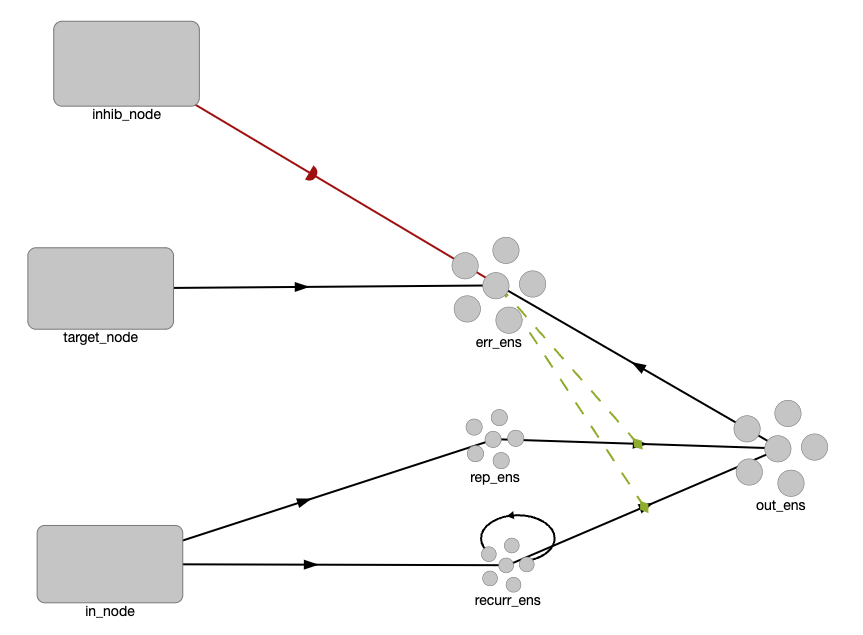

## 3. Visualizing results


In [42]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

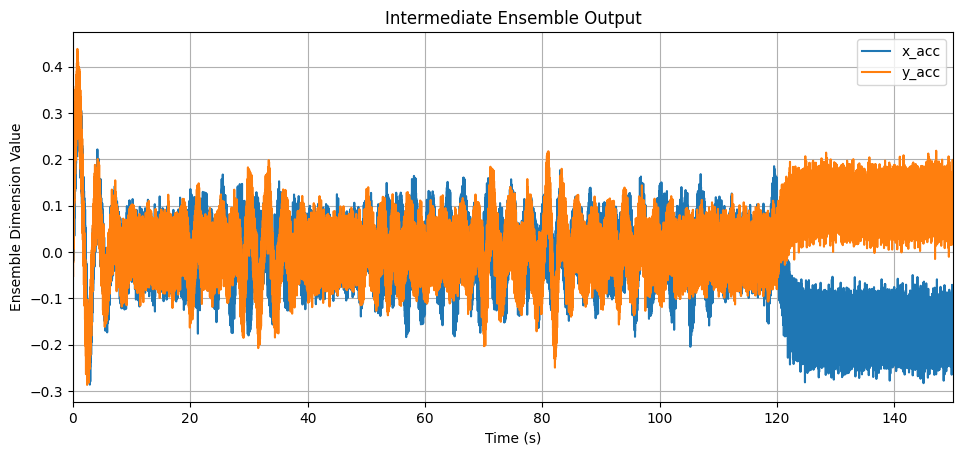

In [10]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

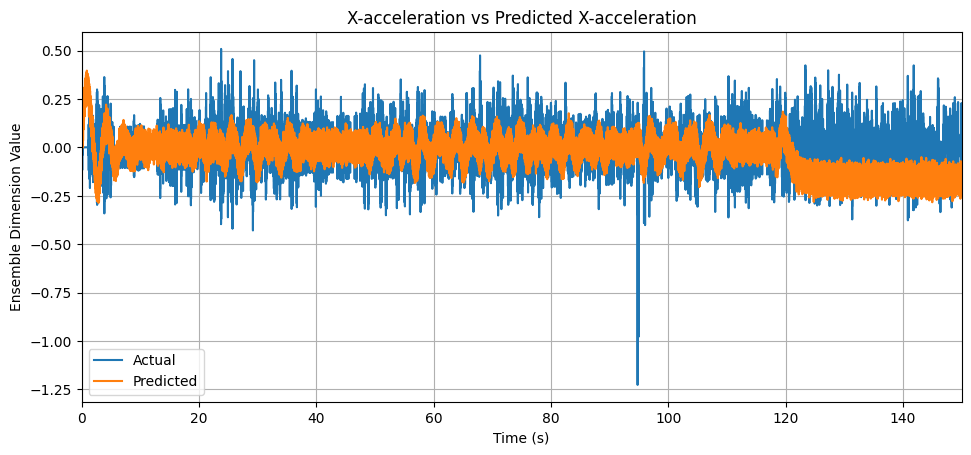

In [11]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

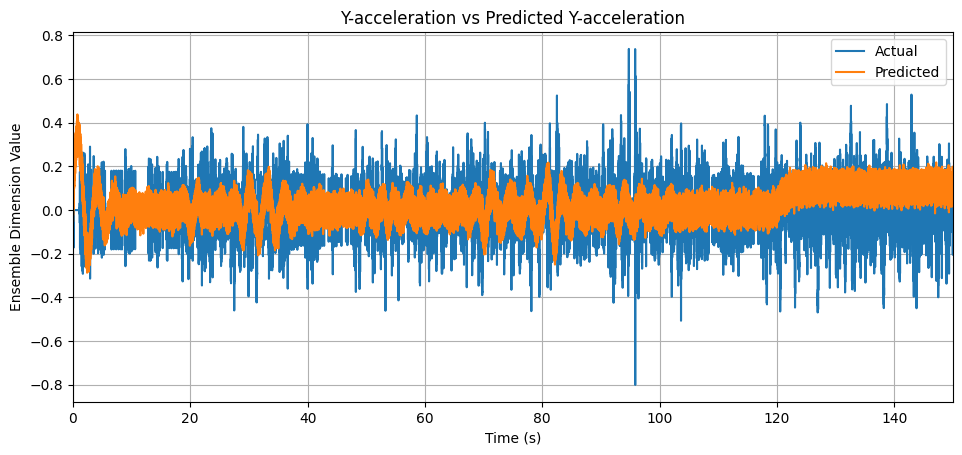

In [12]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

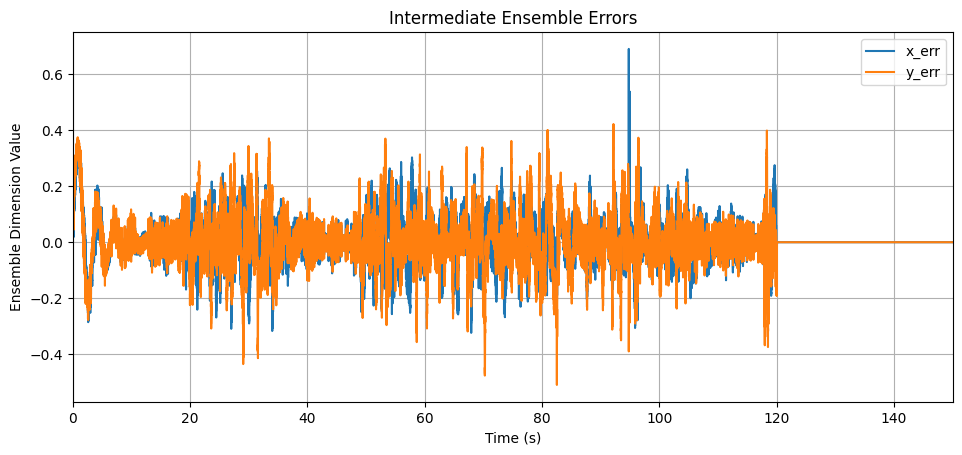

In [13]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

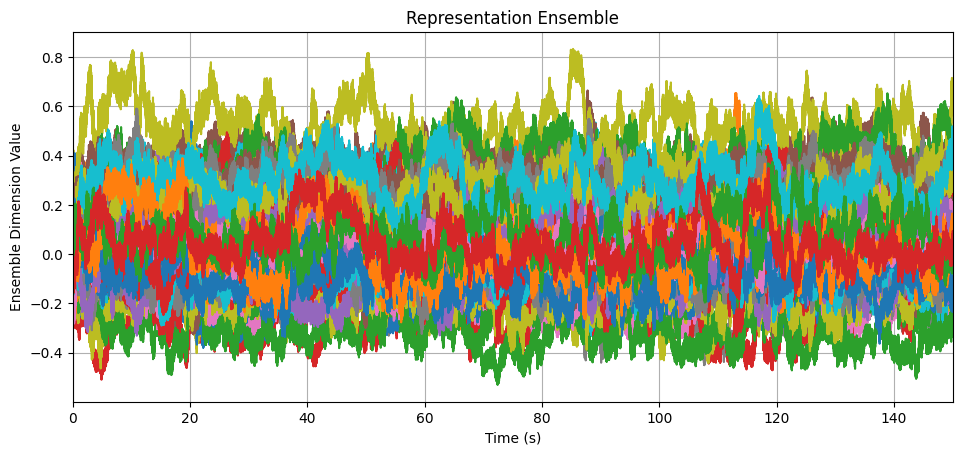

In [18]:
# For the representation ensemble:

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_rep])
pl.set_title("Representation Ensemble")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.grid()

/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


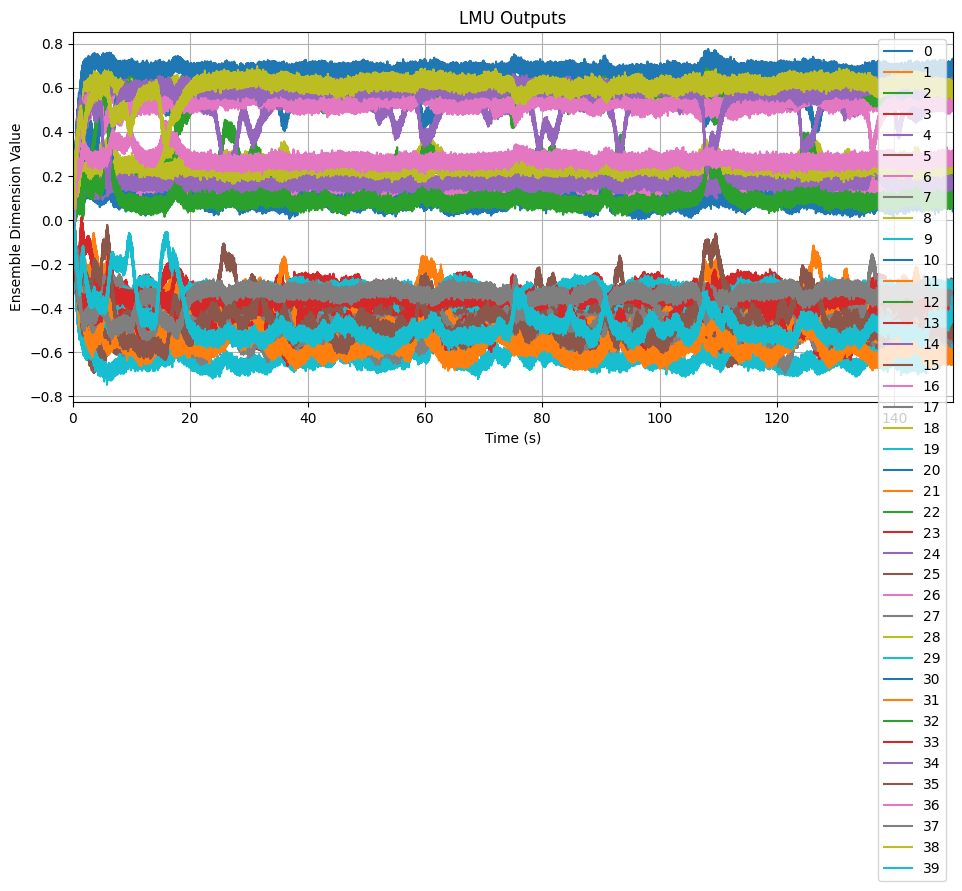

In [43]:
# For the LMU output ensemble:

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_lmu_rep])
pl.set_title("LMU Outputs")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend([i for i in range(40)])
pl.grid()

Maybe specific LMU outputs have some correlation with the outputs? Trying to isolate for the ones that have more variation in their pattern.

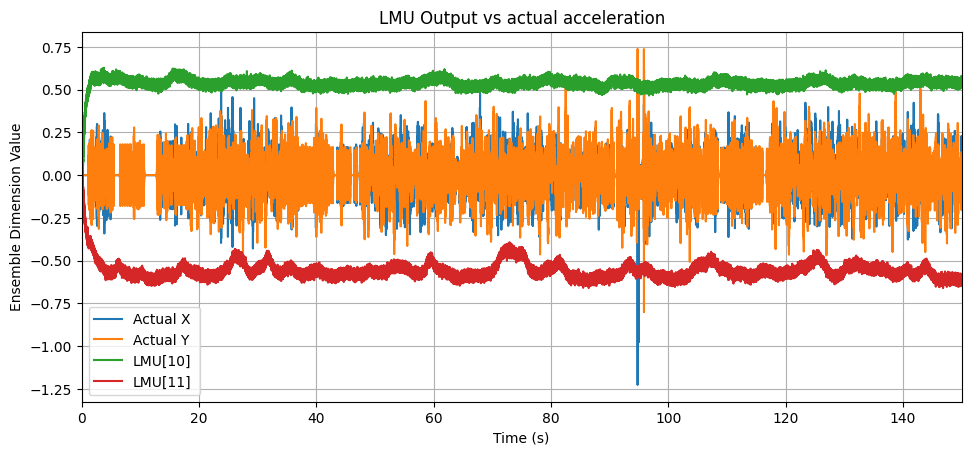

In [58]:
# LMU output vs expected
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_lmu_rep][:,6])
pl.plot(sim.trange(), sim.data[p_lmu_rep][:,7])
pl.set_title("LMU Output vs actual acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual X ", "Actual Y ", "LMU[10]", "LMU[11]"])
pl.grid()

It looks like some of the patterns seem to be flipped. I'm not sure if this is intentional, but in this case, wouldn't it be that the coefficients are cancelling each other out?

In [23]:
sim.data[p_lmu_rep].shape

(150000, 40)

## 4. Evaluation

In [15]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [16]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.09705727347012798
Root Mean_Squared Error: 0.12851833298798995

Y-Acceleration Error
Mean Absolute Error: 0.09607110032547286
Root Mean_Squared Error: 0.12865721286791182

